<a href="https://colab.research.google.com/github/jjangmo91/Cervus-nippon_Anmado-Is./blob/main/GF_SG_test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
!pip install rasterio

In [ ]:
# 필요한 모듈 임포트
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from osgeo import gdal
import requests
import json
import geopandas as gpd
import os
import shutil
import psutil
from google.colab import drive
import zipfile
import glob
import rasterio
from rasterio import mask
import numpy.ma as ma  # 마스킹된 배열을 처리하기 위한 모듈

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-jjangmo91')

Google Drive에 저장된 데이터를 가져옵니다.

In [ ]:
# Google Drive 마운트
drive.mount('/content/drive')

# 데이터 폴더 경로 설정
data_dir = '/content/drive/MyDrive/Deer2/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# TIFF 파일 목록 가져오기
tiff_files = glob.glob(os.path.join(data_dir, 'synseries_sg_anmado_*.tif'))

# 파일명에서 시작일과 종료일 추출하여 데이터프레임 생성
file_dates = []

for file_path in tiff_files:
    # 파일명 추출
    file_name = os.path.basename(file_path)

    # 파일명에서 연도 추출 (예: 'synseries_sg_anmado_2020-0000000000-0000000000.tif'에서 '2020' 추출)
    date_str = file_name.split('_')[3].split('-')[0]  # '2020'

    # 문자열을 날짜 형식으로 변환 (연도만 존재하므로 연도 시작일과 종료일로 간주)
    start_date = pd.to_datetime(date_str, format='%Y')
    end_date = pd.to_datetime(date_str, format='%Y') + pd.offsets.YearEnd(0)

    file_dates.append({'file_path': file_path, 'start_date': start_date, 'end_date': end_date})

# 데이터프레임 생성
files_df = pd.DataFrame(file_dates)

# 시작일 순으로 정렬
files_df = files_df.sort_values(by='start_date').reset_index(drop=True)

print(files_df)

                                           file_path start_date   end_date
0  /content/drive/MyDrive/Deer2/synseries_sg_anma... 2014-01-01 2014-12-31
1  /content/drive/MyDrive/Deer2/synseries_sg_anma... 2015-01-01 2015-12-31
2  /content/drive/MyDrive/Deer2/synseries_sg_anma... 2016-01-01 2016-12-31
3  /content/drive/MyDrive/Deer2/synseries_sg_anma... 2017-01-01 2017-12-31
4  /content/drive/MyDrive/Deer2/synseries_sg_anma... 2018-01-01 2018-12-31
5  /content/drive/MyDrive/Deer2/synseries_sg_anma... 2019-01-01 2019-12-31
6  /content/drive/MyDrive/Deer2/synseries_sg_anma... 2020-01-01 2020-12-31


In [49]:
# Anmado & Songido GeoJSON URL
url_anmado = 'https://github.com/jjangmo91/Cervus-nippon_Anmado-Is./raw/main/anmado.geojson'
url_songido = 'https://github.com/jjangmo91/Cervus-nippon_Anmado-Is./raw/main/songido.geojson'

# GeoJSON 파일을 GEE FeatureCollection으로 변환하는 함수
def geojson_to_feature_collection(url):
    response = requests.get(url)
    geojson = response.json()
    features = []
    for feature in geojson['features']:
        geom = feature['geometry']
        feat = {'type': 'Feature', 'geometry': geom, 'properties': feature['properties']}
        features.append(feat)
    return features

# Anmado 및 Songido FeatureCollection 생성
anmado_features = geojson_to_feature_collection(url_anmado)
songido_features = geojson_to_feature_collection(url_songido)

# 각 지역의 FRTP_CD 값에 대해 AOI 설정
frtp_values = ['0', '1', '2', '3']
aoi_dict_anmado = {}
aoi_dict_songido = {}

for frtp_value in frtp_values:
    # Anmado의 해당 FRTP_CD 값을 가진 Feature 추출
    filtered_anmado_features = [feat for feat in anmado_features if feat['properties']['FRTP_CD'] == frtp_value]

    if len(filtered_anmado_features) == 0:
        print(f"Anmado FRTP_CD {frtp_value}에 대한 Feature가 없습니다.")
    else:
        # GeoPandas를 사용하여 Feature를 GeoDataFrame으로 변환
        gdf_anmado = gpd.GeoDataFrame.from_features(filtered_anmado_features, crs='EPSG:4326')

        # AOI 설정 (MultiPolygon으로 결합)
        aoi_anmado = gdf_anmado.unary_union
        aoi_dict_anmado[frtp_value] = aoi_anmado

        print(f"Anmado FRTP_CD {frtp_value}에 대한 AOI가 설정되었습니다.")

    # Songido의 해당 FRTP_CD 값을 가진 Feature 추출
    filtered_songido_features = [feat for feat in songido_features if feat['properties']['FRTP_CD'] == frtp_value]

    if len(filtered_songido_features) == 0:
        print(f"Songido FRTP_CD {frtp_value}에 대한 Feature가 없습니다.")
    else:
        # GeoPandas를 사용하여 Feature를 GeoDataFrame으로 변환
        gdf_songido = gpd.GeoDataFrame.from_features(filtered_songido_features, crs='EPSG:4326')

        # AOI 설정 (MultiPolygon으로 결합)
        aoi_songido = gdf_songido.unary_union
        aoi_dict_songido[frtp_value] = aoi_songido

        print(f"Songido FRTP_CD {frtp_value}에 대한 AOI가 설정되었습니다.")

<ipython-input-49-6c6b76e36c6c>:36: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_anmado = gdf_anmado.unary_union
<ipython-input-49-6c6b76e36c6c>:51: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  aoi_songido = gdf_songido.unary_union


Anmado FRTP_CD 0에 대한 AOI가 설정되었습니다.
Songido FRTP_CD 0에 대한 AOI가 설정되었습니다.
Anmado FRTP_CD 1에 대한 AOI가 설정되었습니다.
Songido FRTP_CD 1에 대한 AOI가 설정되었습니다.
Anmado FRTP_CD 2에 대한 AOI가 설정되었습니다.
Songido FRTP_CD 2에 대한 AOI가 설정되었습니다.
Anmado FRTP_CD 3에 대한 AOI가 설정되었습니다.
Songido FRTP_CD 3에 대한 AOI가 설정되었습니다.


래스터 데이터의 CRS를 AOI 좌표계와 일치시켜줍니다.

In [50]:
# 래스터 데이터의 CRS 설정
raster_crs = 'EPSG:EPSG:32652'

# AOI의 좌표계를 래스터 데이터의 CRS로 변환
anmado_gdf = gpd.GeoDataFrame.from_features(anmado_features, crs='EPSG:4326').to_crs(raster_crs)
songido_gdf = gpd.GeoDataFrame.from_features(songido_features, crs='EPSG:4326').to_crs(raster_crs)
print(f"Transformed Anmado AOI CRS: {anmado_gdf.crs}")
print(f"Transformed Songido AOI CRS: {songido_gdf.crs}")

CRSError: Invalid projection: EPSG:EPSG:32652: (Internal Proj Error: proj_create: unrecognized format / unknown name)

데이터에 이미 GF-SG가 적용되었으므로, 대상지역의 NDVI 시계열 데이터를 추출하고 시각화합니다.

In [51]:
# 데이터에 이미 GF-SG가 적용되었으므로, 대상지역의 NDVI 시계열 데이터를 추출하고 시각화합니다.
import numpy.ma as ma  # 마스킹된 배열을 처리하기 위한 모듈

# 결과를 저장할 딕셔너리 초기화
ndvi_data_by_region = {'anmado': {frtp_value: [] for frtp_value in frtp_values},
                       'songido': {frtp_value: [] for frtp_value in frtp_values}}

for idx, row in files_df.iterrows():
    file_path = row['file_path']
    start_date = row['start_date']
    end_date = row['end_date']

    # TIFF 파일 열기
    with rasterio.open(file_path) as src:
        band_count = src.count  # 밴드 수 확인
        raster_crs = src.crs  # 래스터의 CRS 가져오기

        # 밴드별 날짜 계산
        band_dates = pd.date_range(start=start_date, end=end_date, periods=band_count)

        # 각 지역에 대해 FRTP_CD 값에 대해 AOI를 래스터의 CRS로 변환
        for region, aoi_dict in [('anmado', aoi_dict_anmado), ('songido', aoi_dict_songido)]:
            transformed_aois = {}
            for frtp_value in frtp_values:
                if frtp_value in aoi_dict:
                    aoi = aoi_dict[frtp_value]

                    # AOI를 GeoDataFrame으로 변환
                    aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs='EPSG:4326')  # 기존 CRS 설정
                    aoi_gdf = aoi_gdf.to_crs(raster_crs)  # 래스터의 CRS로 변환

                    # 변환된 AOI를 shapely.geometry로 추출
                    transformed_aoi = aoi_gdf.iloc[0].geometry
                    transformed_aois[frtp_value] = transformed_aoi
                else:
                    print(f"{region.capitalize()} FRTP_CD {frtp_value}에 대한 AOI가 없습니다.")

            for band_idx in range(1, band_count + 1):
                # 각 FRTP_CD 값에 대해 AOI를 적용하여 NDVI 평균값 계산
                for frtp_value in frtp_values:
                    if frtp_value in transformed_aois:
                        aoi = transformed_aois[frtp_value]

                        # rasterio의 mask 함수 사용하여 AOI에 해당하는 부분 추출
                        try:
                            ndvi_masked, _ = mask.mask(
                                src,
                                [aoi],
                                crop=True,
                                all_touched=True,
                                indexes=band_idx,
                                filled=False  # filled를 False로 설정하여 마스크된 배열 반환
                            )
                            ndvi_masked = ndvi_masked[0]  # 첫 번째 배열 선택

                            # 데이터를 부동소수점으로 변환
                            ndvi_masked = ndvi_masked.astype('float32')

                            # NDVI 값 보정 (10,000으로 나누기)
                            ndvi_masked = ndvi_masked / 10000.0

                            # NDVI 평균값 계산 (마스크된 값을 무시)
                            ndvi_mean = ndvi_masked.mean()
                        except ValueError as e:
                            print(f"ValueError for {region.capitalize()} FRTP_CD {frtp_value}: {e}")
                            ndvi_mean = np.nan

                        # 결과 저장
                        ndvi_data_by_region[region][frtp_value].append({
                            'date': band_dates[band_idx - 1],
                            'NDVI': ndvi_mean
                        })

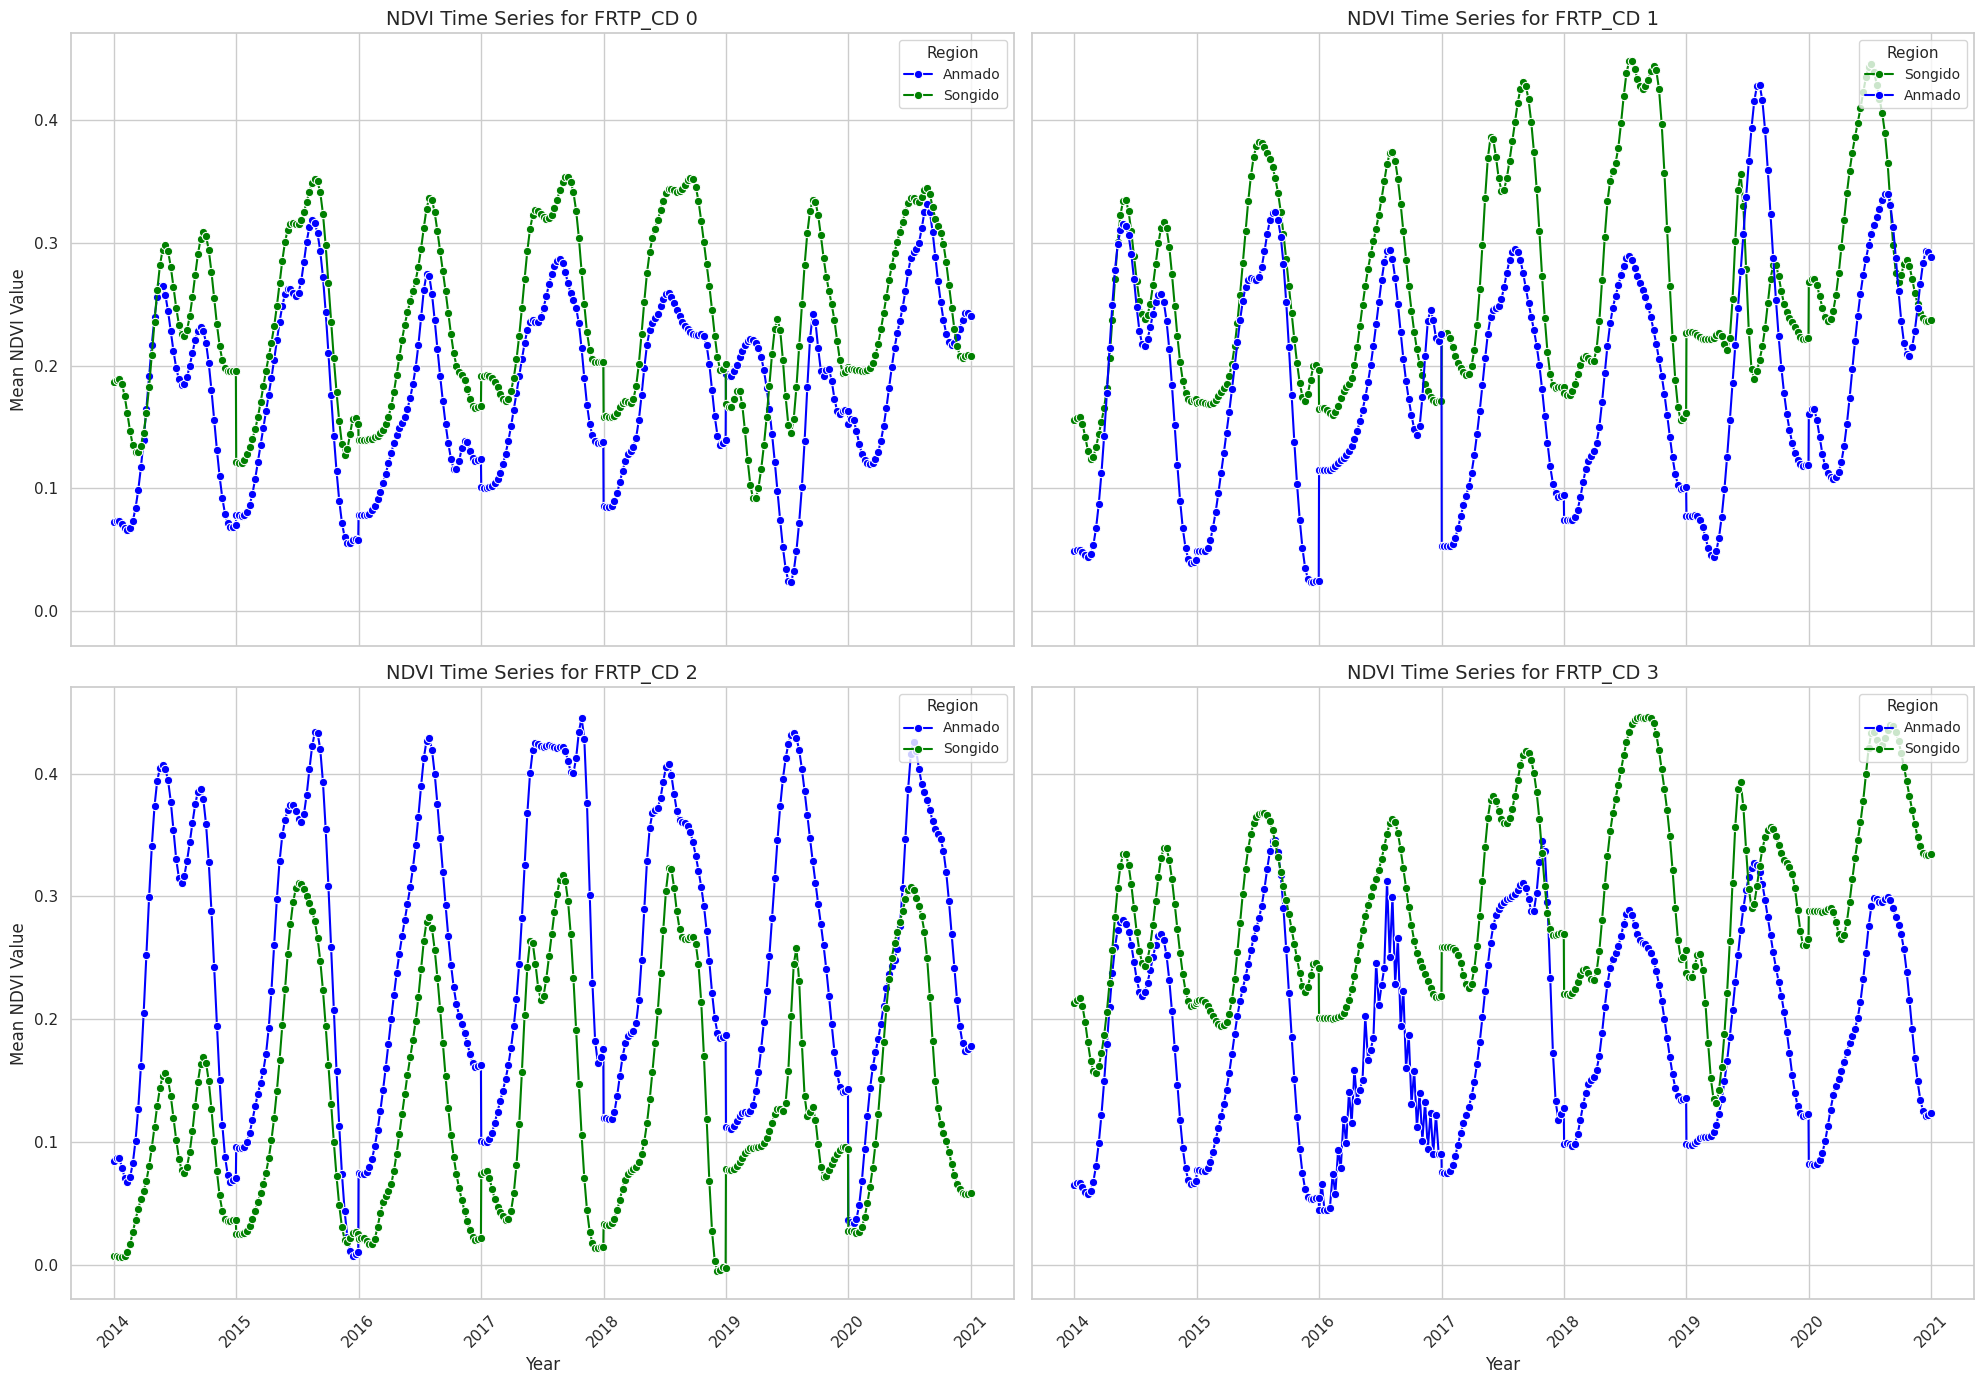

In [58]:
# 데이터프레임 생성
ndvi_df_list = []

for region, region_data in ndvi_data_by_region.items():
    for frtp_value, data_list in region_data.items():
        df = pd.DataFrame(data_list)
        df['FRTP_CD'] = frtp_value
        df['Region'] = region.capitalize()
        ndvi_df_list.append(df)

# 모든 데이터를 하나의 데이터프레임으로 결합
ndvi_df = pd.concat(ndvi_df_list)

# 날짜 형식 변환 및 정렬
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])
ndvi_df = ndvi_df.sort_values(by='date')

# FRTP_CD를 카테고리형으로 변환하고 순서 지정
frtp_order = ['0', '1', '2', '3']
ndvi_df['FRTP_CD'] = pd.Categorical(ndvi_df['FRTP_CD'], categories=frtp_order, ordered=True)

# 시각화 스타일 설정
sns.set(style="whitegrid")

import matplotlib.dates as mdates

# FRTP별로 4개의 그래프를 그리고 각 그래프에서 Anmado와 Songido를 비교
fig, axes = plt.subplots(2, 2, figsize=(20, 14), sharex=True, sharey=True)
axes = axes.flatten()

palette = {'Anmado': 'blue', 'Songido': 'green'}

for i, frtp_value in enumerate(frtp_order):
    ax = axes[i]
    sns.lineplot(
        data=ndvi_df[ndvi_df['FRTP_CD'] == frtp_value],
        x='date',
        y='NDVI',
        hue='Region',
        marker='o',
        palette=palette,
        ax=ax
    )
    ax.set_title(f'NDVI Time Series for FRTP_CD {frtp_value}', fontsize=14)
    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('Mean NDVI Value', fontsize=12)
    ax.legend(title='Region', fontsize=10, title_fontsize=11, loc='upper right')
    ax.tick_params(axis='x', rotation=45)
    ax.xaxis.set_major_locator(mdates.YearLocator())  # 연도마다 주요 틱 생성
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # 연도 형식 지정

plt.tight_layout()
plt.show()